In [22]:
import sys, re
sys.path.append('../python/')
from data.IGRA import Monthly
from data.NCDC import GHCND
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs
from sklearn.cross_decomposition import CCA
import statsmodels.api as sm

In [23]:
%matplotlib nbagg

In [4]:
from IPython.display import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('png', 'pdf')

In [24]:
# IGRA (radiosonde archive)
ista = Monthly.read_stations('../../data/IGRA/igra2-station-list.txt').query('lat<=-60')

In [25]:
from pca import pca

## 500 mb $\Phi$

In [26]:
mly = Monthly.tar_to_xarray('../../data/IGRA/IGRA-mly.tar.gz', ista.id, tar=re.compile('ghgt'))

In [27]:
gp = mly.data.sel(type='value', lvl=500)['ghgt']

In [30]:
# longest record
ista.loc[89592]

id            AYM00089592
lat              -66.5519
lon               93.0147
elev                 43.4
state                 NaN
name               MIRNYJ
first_year           1956
last_year            2017
nobs                33855
Name: 89592, dtype: object

In [28]:
pc = pca.probPCA(gp.to_masked_array(), convergence_test='data_loss').run(20000)

 8590/20000 [ 42%] ████████████                   ETA: 102s | Loss: 158082.031

In [29]:
wr, zr = pc.rotate()
w, z = pc.scale(wr, zr)

<IPython.core.display.Javascript object>


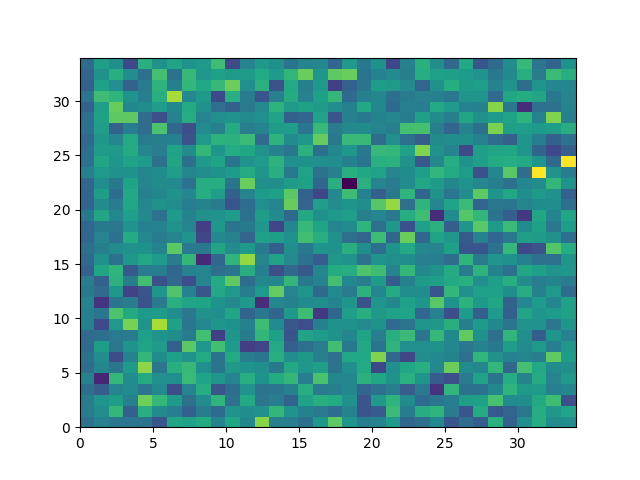

In [30]:
plt.figure()
plt.pcolormesh(w)

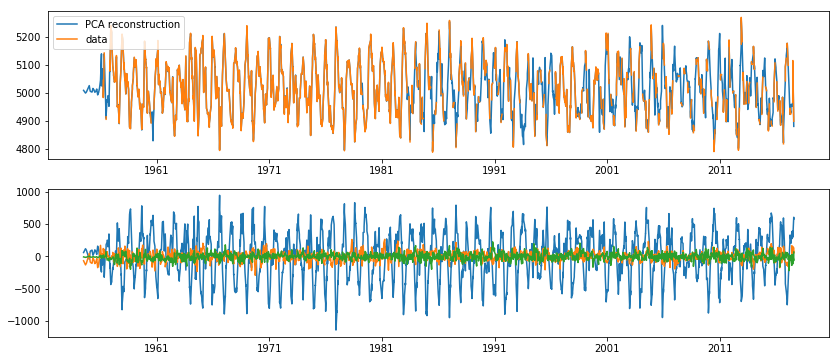

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(14, 6))

axs[0].plot(gp.time, pc.x[22, :], label='PCA reconstruction')
axs[0].plot(gp.time, gp.sel(station=89592), label='data')
axs[0].legend()

axs[1].plot(gp.time, z[:,0])
axs[1].plot(gp.time, z[:,1])
axs[1].plot(gp.time, z[:,2]);

**Top:** Comparison original data and reconstruction from (full dimensional) variational Bayesian PCA (fully factorized approximations).   
**Botton:** First 3 principal components, according to the scaling function in `pca`. Seems to be more or less correct.   

The station chosen is the one with the most records (MIRNYJ).

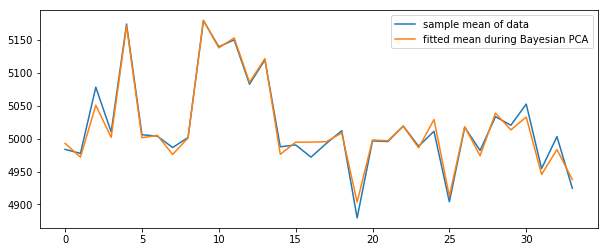

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(gp.mean('time'), label='sample mean of data')
plt.plot(pc.mu, label='fitted mean during Bayesian PCA')
plt.legend()

Comparison between sample mean and mean fitted as part of the variational Bayesian PCA procedure, by station.

In [18]:
def cbar(p, ticks='right', center=False, width=.01, **kwargs):
    bb = p.axes.get_position()
    x, s = kwargs.popitem()
    x = getattr(bb, x) + s
    cax = p.figure.add_axes([x, bb.y0, width, bb.y1-bb.y0])
    plt.colorbar(p, cax=cax)
    cax.yaxis.set_ticks_position(ticks)
    p.axes.coastlines()
    p.axes.gridlines()
    p.axes.set_extent((-180, 180, -90, -65), crs.PlateCarree())
    if center is not False:
        lim = np.abs(p.get_clim()).max() if isinstance(center, bool) else center
        p.set_clim(-lim, lim)

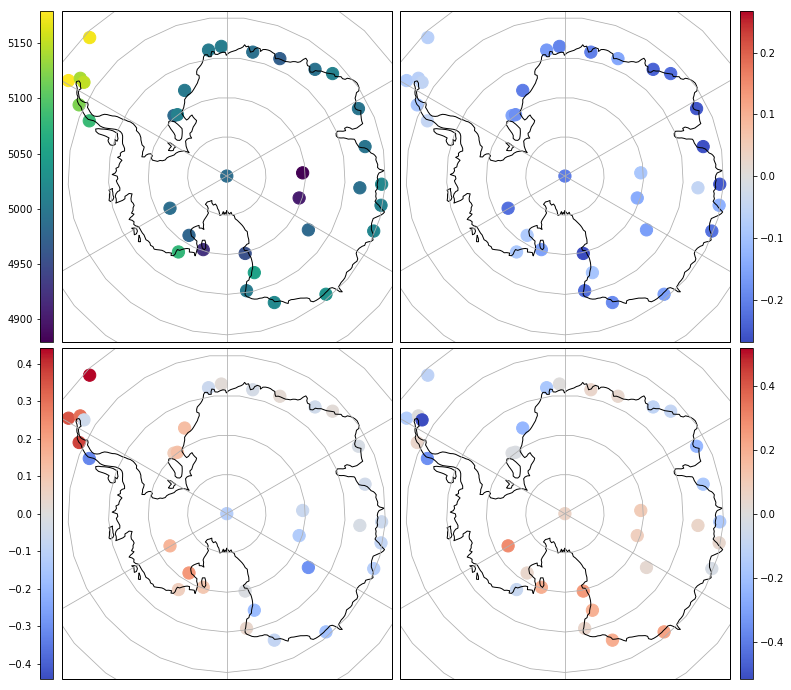

In [19]:
width = 0.015
x0 = -0.025
x1 = 0.01
size = 150

fig, axs = plt.subplots(2, 2, figsize=(12, 12.3), subplot_kw={'projection': crs.SouthPolarStereo()})
fig.subplots_adjust(hspace=0.02, wspace=0.02)

plt.set_cmap('viridis')
cbar(axs[0, 0].scatter(*ista.loc[gp.station][['lon', 'lat']].as_matrix().T, c=gp.mean('time'), s=size,
                       transform=crs.PlateCarree()), ticks='left', x0=x0, width=width)

plt.set_cmap('coolwarm')
cbar(axs[0, 1].scatter(*ista.loc[gp.station][['lon', 'lat']].as_matrix().T, c=w[:, 0], s=size,
                       transform=crs.PlateCarree()), x1=x1, width=width, center=True)
cbar(axs[1, 0].scatter(*ista.loc[gp.station][['lon', 'lat']].as_matrix().T, c=w[:, 1], s=size,
                       transform=crs.PlateCarree()), ticks='left', x0=x0, width=width, center=True)
cbar(axs[1, 1].scatter(*ista.loc[gp.station][['lon', 'lat']].as_matrix().T, c=w[:, 2], s=size,
                       transform=crs.PlateCarree()), x1=x1, width=width, center=True)

Mean (upper left) and loading matrixes corresponding to the first 3 principal components of the 500mb geopotential field. Data from IGRA. **Remember that the sign of the loadings and PCs is undetermined.**

In [31]:
gpERA = xr.open_dataarray('../../data/analyses/ERA/ERA-GP500-SH.nc').sel(lat=slice(-60, None)).squeeze() / 9.8

In [105]:
gpEm = gpERA.mean('time')

In [32]:
gpEs = gpERA.stack(loc=['lon', 'lat'])
gpX = xr.DataArray(pc.x, coords=[('loc', gp.station), ('time', gp.time)])
X, Y = xr.align(gpX, gpEs, exclude=['loc', 'station'])

In [22]:
import gc
gc.collect()

11480

In [132]:
cca = CCA().fit(X.T, Y)

In [133]:
x, y = cca.fit_transform(X.T, Y)

In [139]:
np.mean(x/y, 0)

array([ 0.37265089,  0.53243707])

<IPython.core.display.Javascript object>


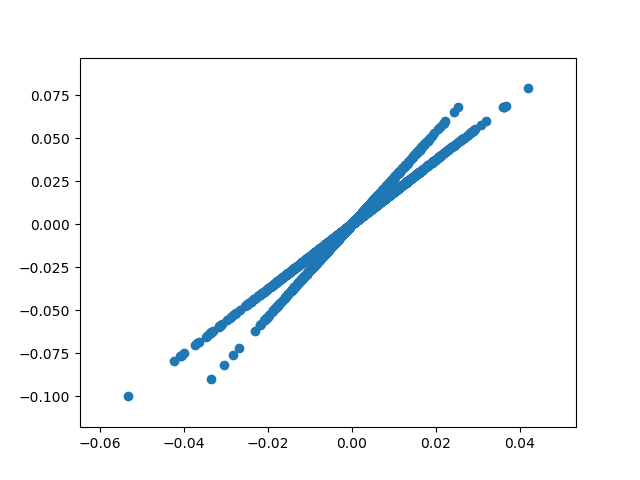

In [135]:
plt.figure()
plt.scatter(x, y)

In [130]:
x.shape

(924, 2)

In [131]:
X.shape

(34, 924)

In [71]:
y = pd.DataFrame(y, index = Y.time, columns=Y.indexes['loc'])

In [61]:
y = xr.DataArray(y, coords=[('time', Y.time), ('loc', Y.indexes['loc'])]).unstack('loc')

In [97]:
def trend(x, plot=False):
    if x.count() == 0:
        return np.nan
    t = sm.tools.add_constant(x.index.values.astype('datetime64[D]').astype(float))
    r = sm.OLS(x, t, missing='drop').fit()
    return r.params.values[1]

In [76]:
yt = xr.DataArray(y.apply(trend, 0).unstack())

In [98]:
Yt = xr.DataArray(pd.DataFrame(y, index = Y.time, columns=Y.indexes['loc']).apply(trend, 0).unstack())

<IPython.core.display.Javascript object>


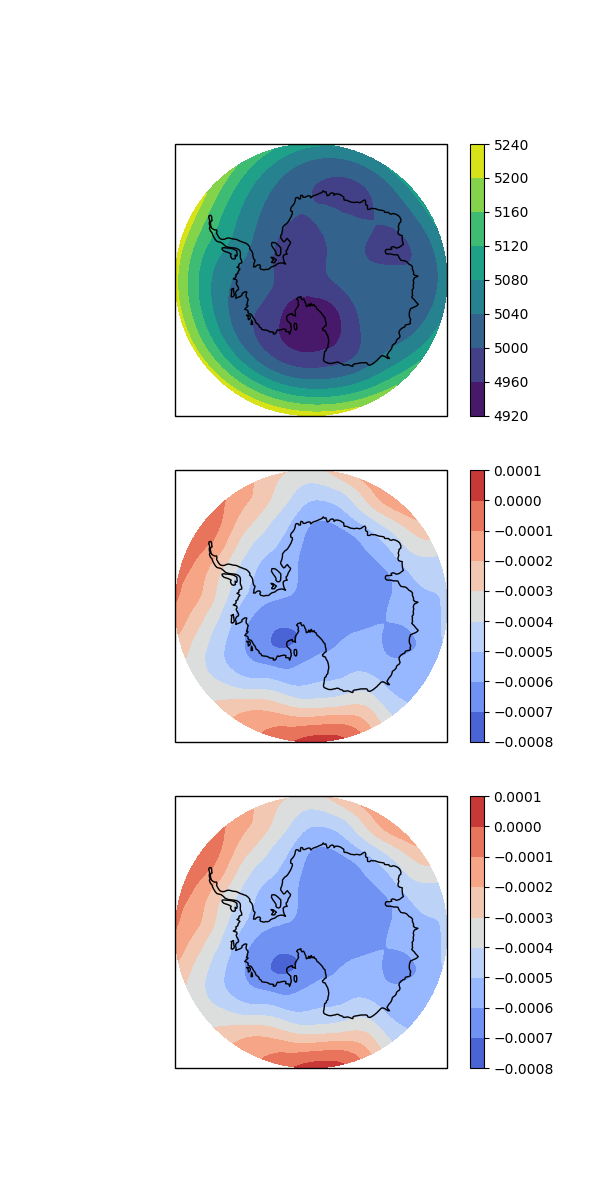

In [123]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12), subplot_kw={'projection': crs.SouthPolarStereo()})
pl = axs[0].contourf(gpEm.lon, gpEm.lat, gpEm, transform=crs.PlateCarree())
plt.colorbar(pl, ax=axs[0])
axs[0].coastlines()

plt.set_cmap('coolwarm')
pl = axs[1].contourf(Yt.lon, Yt.lat, Yt.T, transform=crs.PlateCarree())
plt.colorbar(pl, ax=axs[1])
axs[1].coastlines()

pl = axs[2].contourf(yt.lon, yt.lat, yt.T, transform=crs.PlateCarree())
plt.colorbar(pl, ax=axs[2])
axs[2].coastlines()